In [1]:
import sys
sys.path.append("../")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from datasets.llff import LLFFDataset
from datasets.llff import *

In [4]:
root_dir = "/scratch/saksham/data/freiburg_small/"

In [5]:
from datasets.colmap_utils import \
    read_cameras_binary, read_images_binary, read_points3d_binary
from datasets.tum import TUMRGBDDataset

In [6]:
tum_path = "/scratch/saksham/data/tum/rgbd_dataset_freiburg1_desk/"
rgb_depth_mapping = TUMRGBDDataset(tum_path).rgb_d_mapping

In [7]:
img_wh = (80, 60)

camdata = read_cameras_binary(os.path.join(root_dir, 'sparse/0/cameras.bin'))
H = camdata[1].height
W = camdata[1].width
focal = camdata[1].params[0] * img_wh[0]/W

In [8]:
imdata = read_images_binary(os.path.join(root_dir, 'sparse/0/images.bin'))

In [9]:
perm = np.argsort([imdata[k].name for k in imdata])

In [10]:
image_paths = [os.path.join(root_dir, 'images', name)
                            for name in sorted([imdata[k].name for k in imdata])]

In [11]:
image_paths = [os.path.join(root_dir, 'images', name)
                            for name in sorted([imdata[k].name for k in imdata])]

In [12]:
w2c_mats = []
bottom = np.array([0, 0, 0, 1.]).reshape(1, 4)
for k in imdata:
    im = imdata[k]
    R = im.qvec2rotmat()
    t = im.tvec.reshape(3, 1)
    w2c_mats += [np.concatenate([np.concatenate([R, t], 1), bottom], 0)]
w2c_mats = np.stack(w2c_mats, 0)
poses = np.linalg.inv(w2c_mats) # (N_images, 3, 4) cam2world matrices

In [13]:
poses = torch.from_numpy(poses).float()

In [14]:
from gradslam.geometry.geometryutils import relative_transformation

In [15]:
poses = relative_transformation(
            poses[0].unsqueeze(0).repeat(poses.shape[0], 1, 1), poses, orthogonal_rotations = True
        )

In [16]:
poses = poses.numpy().astype('float64')

In [17]:
poses.shape

(101, 4, 4)

In [18]:
np.save("colmap2.npy", poses[:30])

In [14]:
bounds = np.zeros((len(poses), 2)) # (N_images, 2)
pts3d = read_points3d_binary(os.path.join(root_dir, 'sparse/0/points3D.bin'))

In [15]:
pts_world = np.zeros((1, 3, len(pts3d))) # (1, 3, N_points)
visibilities = np.zeros((len(poses), len(pts3d))) # (N_images, N_points)
for i, k in enumerate(pts3d):
    pts_world[0, :, i] = pts3d[k].xyz
    for j in pts3d[k].image_ids:
        visibilities[j-1, i] = 1

In [16]:
depths = ((pts_world-poses[..., 3:4])*poses[..., 2:3]).sum(1) # (N_images, N_points)
for i in range(len(poses)):
    visibility_i = visibilities[i]
    zs = depths[i][visibility_i==1]
    bounds[i] = [np.percentile(zs, 0.1), np.percentile(zs, 99.9)]
# permute the matrices to increasing order
poses = poses[perm]
bounds = bounds[perm]

In [17]:
poses.shape

(101, 3, 4)

In [18]:
poses = np.concatenate([poses[..., 0:1], -poses[..., 1:3], poses[..., 3:4]], -1)

In [19]:
# poses = poses[:30]
# image_paths = image_paths[:30]
# bounds = bounds[:30]

In [20]:
poses, _ = center_poses(poses)

In [21]:
distances_from_center = np.linalg.norm(poses[..., 3], axis=1)

In [22]:
val_idx = np.argmin(distances_from_center) # choose val image as the closest to
                                                   # center image

In [23]:
bounds.min()

2.0559904843130434

In [24]:
bounds.max()

28.39163776138985

In [25]:
near_original = bounds.min()

In [26]:
scale_factor = near_original*0.75

In [27]:
scale_factor

1.5419928632347826

In [28]:
bounds2 = bounds/scale_factor
# poses[..., 3] /= scale_factor

In [29]:
bounds2.min(), bounds2.max()

(1.3333333333333333, 18.41230166385469)

In [30]:
img_wh=(504, 378)

directions = get_ray_directions(img_wh[1], img_wh[0], focal) # (H, W, 3)

In [31]:
directions.shape

torch.Size([378, 504, 3])

In [32]:
i = 15

In [33]:
image_path = image_paths[i]
image_id = os.path.basename(image_path)
depth_id = rgb_depth_mapping[image_id]
depth_path = os.path.join((os.path.join(tum_path,"depth")),depth_id)

In [34]:
img_wh = (504, 378)

img = Image.open(image_path).convert('RGB')
#img = img.resize(img_wh, Image.LANCZOS)

In [35]:
img.size

(640, 480)

In [36]:
depth = cv2.imread(depth_path, -1)
depth = cv2.resize(depth, (img_wh))
depth = depth/5000

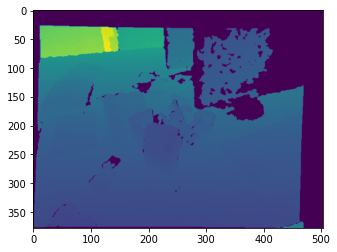

In [37]:
plt.imshow(depth)

In [48]:
mask = 1 - (depth==0).astype('uint8')

In [49]:
mask.shape

(378, 504)

In [52]:
mask.sum()/(mask.shape[1]*mask.shape[0])

0.7577947845804989

In [53]:
mask

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [60]:
near_original = bounds.min()
scale_factor = near_original*0.75
near_depth_colmap = bounds.min() # 1% percentile
far_depth_colmap = bounds.max() # 99% percentile

In [61]:
near_depth_colmap, far_depth_colmap

(2.0559904843130434, 28.39163776138985)

In [62]:
# At scene level, 
# depths = depths[depths>0]# 
# np.percentile(depths.flatten(), 99.9) -> near_depth_tum -> 3.8844
# np.percentile(depths.flatten(),0.01 ) -> far_depth_tum -> 0.4482

near_depth_tum = 0.4482
far_depth_tum = 3.8844

In [63]:
scaled_depth = (far_depth_colmap - near_depth_colmap)*(depth - near_depth_tum)/(far_depth_tum - near_depth_tum) + near_depth_colmap

In [64]:
scaled_depth[scaled_depth < near_original] = near_original

In [65]:
scaled_depth.min()

2.0559904843130434

In [66]:
scaled_depth = scaled_depth/scale_factor

In [67]:
scaled_depth.min(), scaled_depth.max()

(1.3333333333333333, 16.46891169317957)

In [42]:
def convert_to_ndc(d):
    return 1 - 1/d

ndc_depth = convert_to_ndc(scaled_depth)

In [43]:
ndc_depth = torch.Tensor(ndc_depth)

In [46]:
ndc_depth = ndc_depth.view(-1)